# Import Python packages

In [67]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pickle
import compress_pickle
from tqdm.notebook import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# Load data

In [68]:
DATASET_PATH = r"/mnt/e/Projects/regression/risk_modelling/data/SCFP2019.csv"
VARIABLES_PATH = r"/mnt/e/Projects/regression/risk_modelling/data/variables.xlsx"

In [69]:
raw_data = pd.read_csv(DATASET_PATH)
raw_data.shape

(28885, 351)

In [70]:
raw_data.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGPSTP,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,1,5,3,1,1,1,1,1,2,10400,3000,0,0.0,67195.781504,1018.117902,0.0,43880.881558,14253.650622,8144.943213,0.0,0.0,67195.781504,2,0,1,0,0,0,0,0,0,0,0,4,2,1,0,0,0,0,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,6000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6000,1,25000,1,0,0,0,0,0,0,0,0,0,0,0,30900.0,317000,0,84000,0,401000,1,33000,0,0,0,33000,1,0,0,0,0,0,0,0,44000,1,0,500000,500000,1,0,0,409900.0,1,0,9900.0,6.100085,1,1,2,1009000,1,4600,1,0,0,1,2,0,0,0,2,0,0,0.0,1100000.0,1,1,0,0,0.0,0,0.0,0.0,0,0,40000,1,1144600.0,1,44600.0,2153600.0,1,0.0,0.0,0,1100000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,2153600.0,0.0,0.0,190000.0,0.0,0.0,0.0,0,190000.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,1,5,3,1,1,1,1,1,2,10400,3000,0,0.0,57014.602488,1018.117902,0.0,31459.843158,16289.886425,8144.943213,0.0,0.0,57014.602488,2,0,1,0,0,0,0,0,0,0,0,4,2,1,0,0,0,0,6,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,

In [71]:
variables_data = pd.read_excel(VARIABLES_PATH, sheet_name="selected")
variables_data.shape

(8, 3)

In [72]:
variables_data.head(3)

,model_var,risky_var,risk_free_var
0,AGE,MMA,CHECKING
1,EDUC,STOCKS,SAVING
2,MARRIED,BOND,CDS


In [73]:
selected_variables = variables_data["model_var"].tolist()
risky_asset_variables = variables_data["risky_var"].dropna().tolist()
risk_free_asset_variables = variables_data["risk_free_var"].dropna().tolist()

## Select variables

In [74]:
processed_data = raw_data[selected_variables + risky_asset_variables + risk_free_asset_variables]
processed_data.shape

(28885, 15)

In [75]:
processed_data.head()

,AGE,EDUC,MARRIED,OCCAT1,OCCAT2,KIDS,NETWORTH,INCOME,MMA,STOCKS,BOND,CHECKING,SAVING,CDS,CALL
0,75,12,2,1,1,0,2153600.0,67195.781504,0,0,401000,6000,0,25000,0
1,75,12,2,1,1,0,2116200.0,57014.602488,0,0,369000,6000,0,29000,0
2,75,12,2,1,1,0,2145000.0,51924.012980,0,0,399000,6000,0,29000,0
3,75,12,2,1,1,0,2552500.0,41742.833964,0,0,800000,6000,0,28000,0
4,75,12,2,1,1,0,2176200.0,50905.895078,0,0,419000,6000,0,27000,0


# Compute risk tolerance

In [76]:
processed_data["total_risky_assets"] = processed_data[risky_asset_variables].sum(axis=1)
processed_data["total_risk_free_assets"] = processed_data[risk_free_asset_variables].sum(axis=1)

/tmp/ipykernel_7426/46392173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data["total_risky_assets"] = processed_data[risky_asset_variables].sum(axis=1)
/tmp/ipykernel_7426/46392173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data["total_risk_free_assets"] = processed_data[risk_free_asset_variables].sum(axis=1)


In [77]:
processed_data["risk_tolerance"] = (
    processed_data["total_risky_assets"]
    / 
    (
        processed_data["total_risky_assets"]
        + processed_data["total_risk_free_assets"]
    )
    )

/tmp/ipykernel_7426/3041037365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data["risk_tolerance"] = (


In [78]:
processed_data.sample(5)

,AGE,EDUC,MARRIED,OCCAT1,OCCAT2,KIDS,NETWORTH,INCOME,MMA,STOCKS,BOND,CHECKING,SAVING,CDS,CALL,total_risky_assets,total_risk_free_assets,risk_tolerance
3132,47,3,1,1,1,1,14700.0,40724.716063,0,0,0,0,0,0,0,0,0,NaN
22761,27,9,2,1,2,0,9840.0,33597.890752,0,0,0,500,1000,0,0,0,1500,0.000000
27408,60,9,1,2,1,0,10889800.0,519240.129800,58000,0,0,15600,600000,1500000,0,58000,2115600,0.026684
11428,41,8,2,1,3,0,81850.0,42760.951866,0,0,0,1000,4000,0,0,0,5000,0.000000
18991,52,9,2,1,2,0,-599.0,20362.358031,0,0,0,0,0,0,0,0,0,NaN


In [79]:
processed_data["risk_tolerance"].isnull().sum()

1575

In [80]:
# remove rows with NaN values for risk_tolerance
processed_data = processed_data.dropna()
processed_data.shape

(27310, 18)

In [81]:
processed_data['risk_tolerance'].describe()

count    27310.000000
mean         0.238249
std          0.367524
min          0.000000
25%          0.000000
50%          0.000000
75%          0.500000
max          1.000000
Name: risk_tolerance, dtype: float64

In [82]:
processed_data["NETWORTH"] = processed_data["NETWORTH"].clip(-200_000, 20_000_000)
processed_data["INCOME"] = processed_data["NETWORTH"].clip(0, 3_000_000)

# Prepare data for modelling

In [83]:
TEST_SIZE = 0.2
RANDOM_SEED = 10
K_FOLDS = 10
SCORING = "r2"

In [84]:
Y = processed_data["risk_tolerance"]
X = processed_data[selected_variables]

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )

In [86]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((21848, 8), (5462, 8), (21848,), (5462,))

In [87]:
X_train.head(3)

,AGE,EDUC,MARRIED,OCCAT1,OCCAT2,KIDS,NETWORTH,INCOME
13999,93,8,2,3,4,0,1730000.0,1730000.0
16151,70,8,1,3,4,0,1079000.0,1079000.0
24576,50,11,2,1,1,0,948300.0,948300.0


In [88]:
column_order = X_train.columns.tolist()

In [89]:
categorical_variables = ["MARRIED", "OCCAT1", "OCCAT2"]

In [90]:
ohe = OneHotEncoder(drop="first")

In [91]:
encodings_train = pd.DataFrame(ohe.fit_transform(X_train[categorical_variables]).toarray())
encodings_train.columns = ohe.get_feature_names_out()

In [92]:
X_train.shape, encodings_train.shape

((21848, 8), (21848, 7))

In [93]:
X_train = X_train.drop(columns=categorical_variables).reset_index(drop=True)
X_train = pd.concat([X_train, encodings_train], axis=1)
X_train.head(3)

,AGE,EDUC,KIDS,NETWORTH,INCOME,MARRIED_2,OCCAT1_2,OCCAT1_3,OCCAT1_4,OCCAT2_2,OCCAT2_3,OCCAT2_4
0,93,8,0,1730000.0,1730000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,70,8,0,1079000.0,1079000.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,50,11,0,948300.0,948300.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [142]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('LGBM', LGBMRegressor()))
models.append(('XGB', XGBRegressor()))

In [143]:
results = []
names = []
for name, model in tqdm_notebook(models):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=SCORING)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

  0%|          | 0/8 [00:00<?, ?it/s]

LR: 0.309090 (0.022987)
LASSO: 0.294223 (0.023530)
EN: 0.294223 (0.023530)
KNN: 0.388701 (0.020496)
DTR: 0.747353 (0.025158)
RFR: 0.838992 (0.013211)
LGBM: 0.468223 (0.022030)
XGB: 0.598612 (0.022963)


## Fine-tune model with grid search

In [94]:
param_grid = {'n_estimators': [50,100,200,300]}
model = RandomForestRegressor()
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=SCORING, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.840566 using {'n_estimators': 300}
0.836212 (0.012889) with: {'n_estimators': 50}
0.838818 (0.012946) with: {'n_estimators': 100}
0.839549 (0.013111) with: {'n_estimators': 200}
0.840566 (0.012372) with: {'n_estimators': 300}


The best model of Random Forest is the one with 300 trees. So, let's choose that as the final model.

## Evaluate the model on the test data

In [95]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=300)

In [96]:
encodings_test = pd.DataFrame(ohe.transform(X_test[categorical_variables]).toarray())
encodings_test.columns = ohe.get_feature_names_out()

X_test = X_test.drop(columns=categorical_variables).reset_index(drop=True)
X_test = pd.concat([X_test, encodings_test], axis=1)
X_test.head(3)

,AGE,EDUC,KIDS,NETWORTH,INCOME,MARRIED_2,OCCAT1_2,OCCAT1_3,OCCAT1_4,OCCAT2_2,OCCAT2_3,OCCAT2_4
0,68,13,0,784950.0,784950.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,74,8,0,4390000.0,3000000.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,61,9,0,9100.0,9100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [97]:
predictions = model.predict(X_test)
print(mean_squared_error(Y_test, predictions))
print(r2_score(Y_test, predictions))

0.017098503871536958
0.8756456500411369


In [98]:
prediction_diff = pd.DataFrame({
    "y_test":Y_test,
    "y_pred":predictions,
    "abs_diff":np.abs(Y_test - predictions),
})
prediction_diff = prediction_diff.sort_values(by="abs_diff", ascending=False)

In [99]:
prediction_diff["abs_diff"].describe()

count    5462.000000
mean        0.061556
std         0.115377
min         0.000000
25%         0.003333
50%         0.015577
75%         0.060762
max         0.978774
Name: abs_diff, dtype: float64

In [100]:
prediction_diff["y_pred"].describe()

count    5462.000000
mean        0.243794
std         0.325427
min         0.000000
25%         0.005120
50%         0.043908
75%         0.460781
max         0.998259
Name: y_pred, dtype: float64

In [101]:
prediction_diff[prediction_diff["abs_diff"] > 0.1].shape[0] / prediction_diff.shape[0]

0.16861955327718783

We see that the prediction errors are high for the cases where the actual risk tolerance is high. So, for a few cases, our model is under-predicting the risk tolerance. The model's prediction is off by more than 10% for only about 17% of the test data.

In [102]:
prediction_diff.sort_values(by="y_test", ascending=False).head()

,y_test,y_pred,abs_diff
17314,1.0,0.021226,0.978774
15928,1.0,0.636346,0.363654
11533,1.0,0.957726,0.042274
20479,1.0,0.646393,0.353607
20900,1.0,0.860185,0.139815


In [103]:
prediction_diff.sort_values(by="abs_diff", ascending=False).head()

,y_test,y_pred,abs_diff
17314,1.000000,0.021226,0.978774
244,0.986842,0.028178,0.958664
25307,0.921986,0.000000,0.921986
1027,1.000000,0.132557,0.867443
19069,0.000000,0.844970,0.844970


# Final model
Now, we train the final model on the entire data. This will be used to make future predictions.

In [104]:
encodings_X = pd.DataFrame(ohe.transform(X[categorical_variables]).toarray())
encodings_X.columns = ohe.get_feature_names_out()

X = X.drop(columns=categorical_variables).reset_index(drop=True)
X = pd.concat([X, encodings_X], axis=1)
X.head(3)

,AGE,EDUC,KIDS,NETWORTH,INCOME,MARRIED_2,OCCAT1_2,OCCAT1_3,OCCAT1_4,OCCAT2_2,OCCAT2_3,OCCAT2_4
0,75,12,0,2153600.0,2153600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,75,12,0,2116200.0,2116200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,75,12,0,2145000.0,2145000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
final_model = RandomForestRegressor(n_estimators = 300)
final_model.fit(X, Y)

RandomForestRegressor(n_estimators=300)

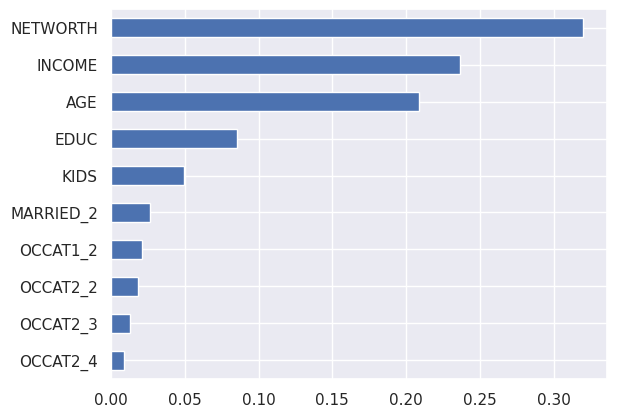

In [106]:
feat_importances = (
    pd.Series(final_model.feature_importances_, index=X.columns)
    )

feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.show()

In [107]:
feat_importances.sort_values()

OCCAT1_4     0.004337
OCCAT1_3     0.008186
OCCAT2_4     0.008655
OCCAT2_3     0.012528
OCCAT2_2     0.018392
OCCAT1_2     0.020997
MARRIED_2    0.026695
KIDS         0.049709
EDUC         0.085191
AGE          0.208653
INCOME       0.236477
NETWORTH     0.320180
dtype: float64

## Save the model

In [108]:
MODEL_PATH = r"/mnt/e/Projects/regression/risk_modelling/model_weights/rf_regression.gz"
COLUMN_PATH = r"/mnt/e/Projects/regression/risk_modelling/model_weights/rf_regression_columns.pkl"
OHE_PATH = r"/mnt/e/Projects/regression/risk_modelling/model_weights/ohe.pkl"

In [109]:
with open(MODEL_PATH, "wb") as file_handle:
    compress_pickle.dump(final_model, file_handle)

In [110]:
with open(COLUMN_PATH, "wb") as file_handle:
    pickle.dump(column_order, file_handle)

In [111]:
with open(OHE_PATH, "wb") as file_handle:
    pickle.dump(ohe, file_handle)